In [1]:
#1 ) Librerías y carga de datos
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
brier_score_loss, make_scorer, f1_score, confusion_matrix)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', 120); pd.set_option('display.width', 160)

# Cargar dataset
df = pd.read_csv('cleaned_stone.csv')
print('Cargado:', df.shape)

Cargado: (4000, 24)


In [3]:
#2) EDA breve y chequeos de rangos
# Distribución objetivo
assert 'stone_risk' in df.columns
print(df['stone_risk'].value_counts(normalize=True).round(3))
df.head()

# Rango rápido de algunas variables
def rstats(s):
    s = s.dropna()
    return pd.Series(dict(min=s.min(), p1=s.quantile(0.01), p50=s.median(), p99=s.quantile(0.99), max=s.max()))
cand = [c for c in
['urine_ph','water_intake','blood_pressure','serum_calcium','gfr','bun','serum_creatinine','oxalate_levels'] if c in
df.columns]
pd.concat({c: rstats(df[c]) for c in cand}, axis=1)

stone_risk
0    0.608
1    0.392
Name: proportion, dtype: float64


,urine_ph,water_intake,blood_pressure,serum_calcium,gfr,bun,serum_creatinine,oxalate_levels
min,4.500576,1.500627,90.019471,5.002407,0.021317,7.000920,0.500273,1.000852
p1,4.540933,1.517954,90.523202,5.121665,0.924264,7.161127,0.509646,1.033007
p50,6.579063,2.512182,111.113002,8.982200,50.247075,16.296667,0.993766,2.432659
p99,7.971747,3.472388,177.900565,10.179000,118.223231,146.758569,4.867531,4.944828
max,7.999886,3.499595,179.991991,10.199344,119.923482,149.999395,4.994009,4.999965


In [4]:
#3) Prevención de leakage y separación X/y
drop_leak = [c for c in ['ckd_pred','ckd_stage','cluster','months'] if c in df.columns]
y = df['stone_risk'].astype(int)
X = df.drop(columns=['stone_risk'] + drop_leak)
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('Numéricas:', len(num_cols), ' | Categóricas:', len(cat_cols), ' | Excluidas (leakage):', drop_leak)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Numéricas: 11  | Categóricas: 8  | Excluidas (leakage): ['ckd_pred', 'ckd_stage', 'cluster', 'months']


In [7]:
#4) Preprocesado + Modelo (baseline LogisticRegression y RandomForest)
# ColumnTransformer
num_tr = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler(with_mean=False))])
cat_tr = Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe',
OneHotEncoder(handle_unknown='ignore'))])
prep = ColumnTransformer([('num', num_tr, num_cols), ('cat', cat_tr, cat_cols)])

base_lr = Pipeline([('prep', prep), ('clf', LogisticRegression(
        solver='lbfgs',        # válido para multinomial; estable
        max_iter=1000,         # más iteraciones
        tol=1e-4,              # tolerancia estándar
        n_jobs=None            # (no aplica en lbfgs, pero lo dejo claro)
        # opcional: class_weight='balanced' si hay desbalance fuerte
))])
rf = Pipeline([('prep', prep), ('clf', RandomForestClassifier(n_estimators=300, random_state=42))])

base_lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

for name, model in [('LogReg', base_lr), ('RF', rf)]:
    p = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, p)
    pr = average_precision_score(y_test, p)
    print(f"{name}: ROC-AUC={roc:.3f} PR-AUC={pr:.3f}")

LogReg: ROC-AUC=0.992 PR-AUC=0.984
RF: ROC-AUC=0.999 PR-AUC=0.998


LogReg – CV ROC-AUC: 0.991 ± 0.003 | CV PR-AUC: 0.982 ± 0.007
RF – CV ROC-AUC: 0.998 ± 0.001 | CV PR-AUC: 0.997 ± 0.001
LogReg – Test ROC-AUC=0.992 PR-AUC=0.984
RF – Test ROC-AUC=0.999 PR-AUC=0.998


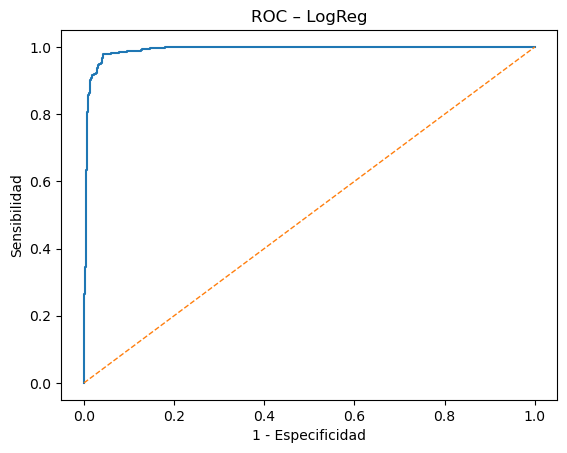

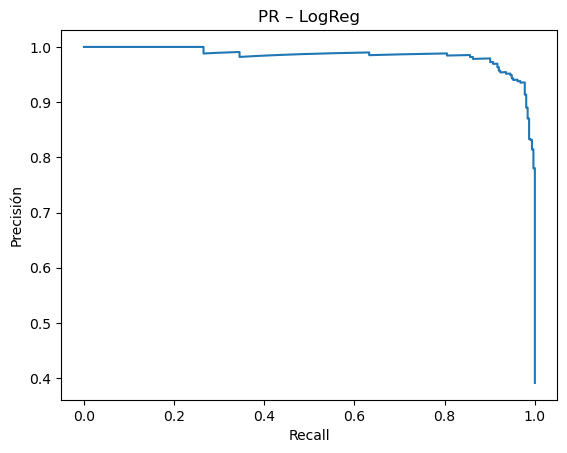

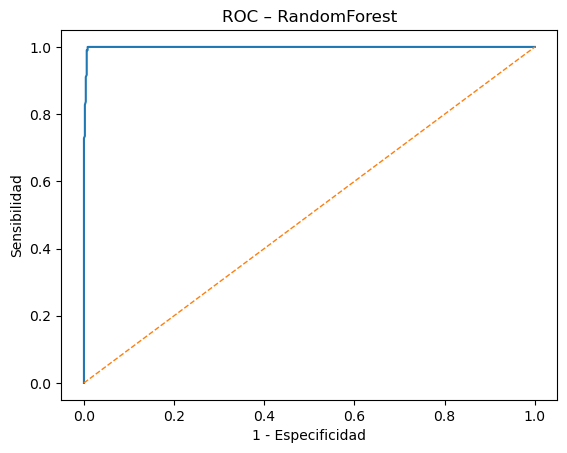

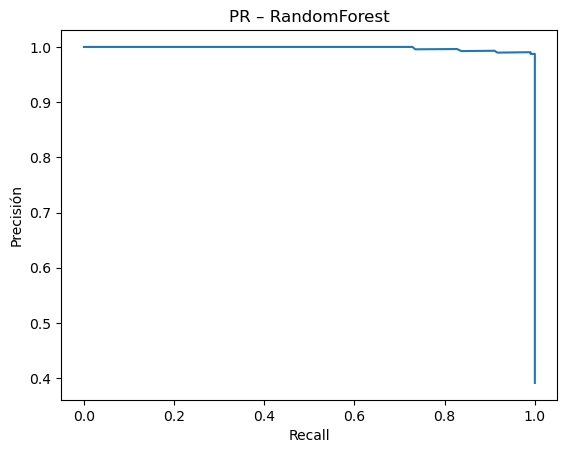

In [10]:
#5) Validación y métricas Curvas ROC y PR
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sc_auprc = make_scorer(average_precision_score, needs_proba=True)
sc_aucroc = make_scorer(roc_auc_score, needs_proba=True)

for name, model in [('LogReg', base_lr), ('RF', rf)]:
    s_roc = cross_val_score(model, X_train, y_train, scoring=sc_aucroc, cv=cv, n_jobs=-1)
    s_pr = cross_val_score(model, X_train, y_train, scoring=sc_auprc, cv=cv, n_jobs=-1)
    print(f"{name} – CV ROC-AUC: {s_roc.mean():.3f} ± {s_roc.std():.3f} | CV PR-AUC: {s_pr.mean():.3f} ± {s_pr.std():.3f}")

# Curvas ROC/PR
def plot_roc_pr(p, y_true, title):
    fpr, tpr, _ = roc_curve(y_true, p)
    prec, rec, _ = precision_recall_curve(y_true, p)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--', lw=1)
    plt.title(f'ROC – {title}')
    plt.xlabel('1 - Especificidad')
    plt.ylabel('Sensibilidad')
    
    plt.figure()
    plt.plot(rec, prec)
    plt.title(f'PR – {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    
p_lr = base_lr.predict_proba(X_test)[:,1]
p_rf = rf.predict_proba(X_test)[:,1]
plot_roc_pr(p_lr, y_test, 'LogReg')
plot_roc_pr(p_rf, y_test, 'RandomForest')

print(f"LogReg – Test ROC-AUC={roc_auc_score(y_test, p_lr):.3f} PR-AUC={average_precision_score(y_test, p_lr):.3f}")
print(f"RF – Test ROC-AUC={roc_auc_score(y_test, p_rf):.3f} PR-AUC={average_precision_score(y_test, p_rf):.3f}")

Brier RF (sin calibrar) = 0.0113 | Brier RF (calibrado) = 0.0054


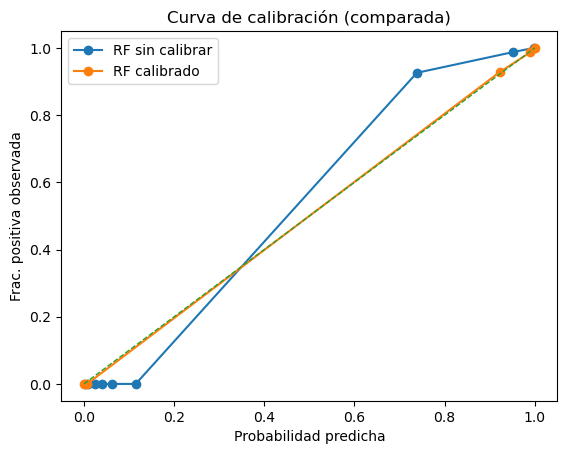

In [11]:
#6) calibración de probabilidades
# Calibración isotónica sobre el mejor modelo (elige RF por defecto)
cal_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
cal_rf.fit(X_train, y_train)
p_rf_uncal = rf.predict_proba(X_test)[:, 1]
p_rf_cal = cal_rf.predict_proba(X_test)[:,1]

print(f"Brier RF (sin calibrar) = {brier_score_loss(y_test, p_rf_uncal):.4f} | Brier RF (calibrado) = {brier_score_loss(y_test, p_rf_cal):.4f}")

pt_u, pp_u = calibration_curve(y_test, p_rf_uncal, n_bins=10, strategy='quantile')
pt_c, pp_c = calibration_curve(y_test, p_rf_cal,   n_bins=10, strategy='quantile')

plt.figure()
plt.plot(pp_u, pt_u, marker='o', label='RF sin calibrar')
plt.plot(pp_c, pt_c, marker='o', label='RF calibrado')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frac. positiva observada')
plt.title('Curva de calibración (comparada)')
plt.legend()

In [12]:
# 7) Selección de umbral (criterios: F1, Youden, precisión mínima, coste, top-k)
def choose_threshold(p, y, policy="f1_max", min_precision=0.80, cost_fn=5.0, cost_fp=1.0, k=None):
    thr = np.linspace(0.0, 1.0, 201)
    best = None
    for t in thr:
        yhat = (p >= t).astype(int)
        tp = ((yhat==1)&(y==1)).sum()
        fp=((yhat==1)&(y==0)).sum()
        fn = ((yhat==0)&(y==1)).sum()
        tn=((yhat==0)&(y==0)).sum()
        prec = tp/(tp+fp+1e-9)
        rec = tp/(tp+fn+1e-9); spec = tn/(tn+fp+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        youden = rec + spec - 1
        cost = cost_fn*fn + cost_fp*fp

        if policy == "f1_max": score = f1
        elif policy == "youden": score = youden
        elif policy == "min_prec": score = rec if prec >= min_precision else -1
        elif policy == "cost": score = -cost
        elif policy == "topk":
            assert k is not None and k > 0
            t = np.partition(p, -k)[-k]
            yhat = (p >= t).astype(int)
            tp = ((yhat==1)&(y==1)).sum()
            fp=((yhat==1)&(y==0)).sum()
            fn = ((yhat==0)&(y==1)).sum()
            tn=((yhat==0)&(y==0)).sum()
            prec = tp/(tp+fp+1e-9)
            rec = tp/(tp+fn+1e-9)
            spec = tn/(tn+fp+1e-9)
            f1 = 2*prec*rec/(prec+rec+1e-9)
            return dict(policy='topk', k=k, threshold=float(t), precision=float(prec),
                        recall=float(rec), specificity=float(spec), f1=float(f1))

        if (best is None) or (score is not None and score > best['score']):
            best = dict(policy=policy, threshold=float(t), precision=float(prec), recall=float(rec),
                        specificity=float(spec), f1=float(f1), youden=float(youden), cost=float(cost),
                        score=float(score if score is not None else -1))
    return best

# Aplicar sobre probabilidades calibradas (p_rf_cal)
res_f1   = choose_threshold(p_rf_cal, y_test, policy="f1_max")
res_yj   = choose_threshold(p_rf_cal, y_test, policy="youden")
res_prec = choose_threshold(p_rf_cal, y_test, policy="min_prec", min_precision=0.80)
res_cost = choose_threshold(p_rf_cal, y_test, policy="cost", cost_fn=5.0, cost_fp=1.0)
res_topk = choose_threshold(p_rf_cal, y_test, policy="topk", k=max(1, int(0.10*len(y_test))))

print(res_f1)
print(res_yj)
print(res_prec)
print(res_cost)
print(res_topk)

{'policy': 'f1_max', 'threshold': 0.525, 'precision': 0.9873817034669168, 'recall': 0.9999999999968051, 'specificity': 0.9917864476365672, 'f1': 0.9936507931476593, 'youden': 0.9917864476333724, 'cost': 4.0, 'score': 0.9936507931476593}
{'policy': 'youden', 'threshold': 0.525, 'precision': 0.9873817034669168, 'recall': 0.9999999999968051, 'specificity': 0.9917864476365672, 'f1': 0.9936507931476593, 'youden': 0.9917864476333724, 'cost': 4.0, 'score': 0.9917864476333724}
{'policy': 'min_prec', 'threshold': 0.005, 'precision': 0.9660493827130677, 'recall': 0.9999999999968051, 'specificity': 0.9774127310041532, 'f1': 0.9827315536571891, 'youden': 0.9774127310009582, 'cost': 11.0, 'score': 0.9999999999968051}
{'policy': 'cost', 'threshold': 0.525, 'precision': 0.9873817034669168, 'recall': 0.9999999999968051, 'specificity': 0.9917864476365672, 'f1': 0.9936507931476593, 'youden': 0.9917864476333724, 'cost': 4.0, 'score': -4.0}
{'policy': 'topk', 'k': 80, 'threshold': 1.0, 'precision': 0.9999

              feature  importance_mean  importance_std
7      oxalate_levels         0.112310        0.007452
12       water_intake         0.041255        0.002485
3       serum_calcium         0.003324        0.003772
8            urine_ph         0.003119        0.004235
13            smoking         0.000096        0.000174
11               diet         0.000067        0.000069
17     weight_changes         0.000051        0.000103
9      blood_pressure        -0.000003        0.000059
18       stress_level        -0.000029        0.000140
1                 gfr        -0.000075        0.000080
15   painkiller_usage        -0.000094        0.000132
16     family_history        -0.000130        0.000099
10  physical_activity        -0.000139        0.000140
14            alcohol        -0.000145        0.000086
0    serum_creatinine        -0.000343        0.000102


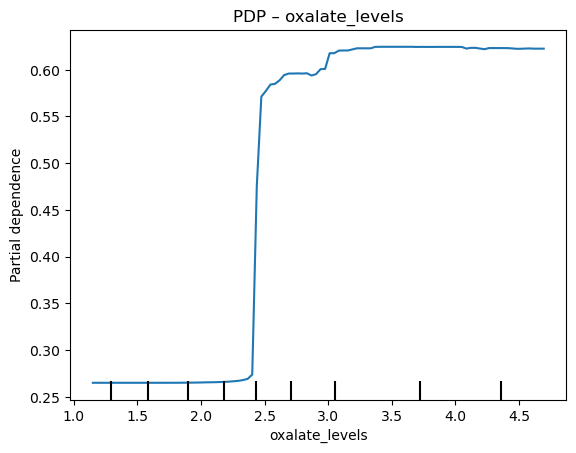

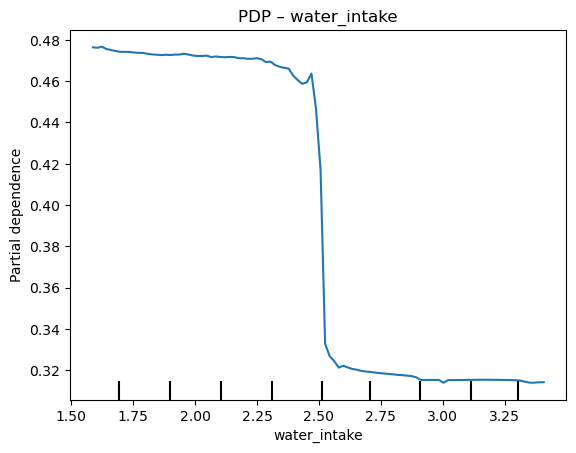

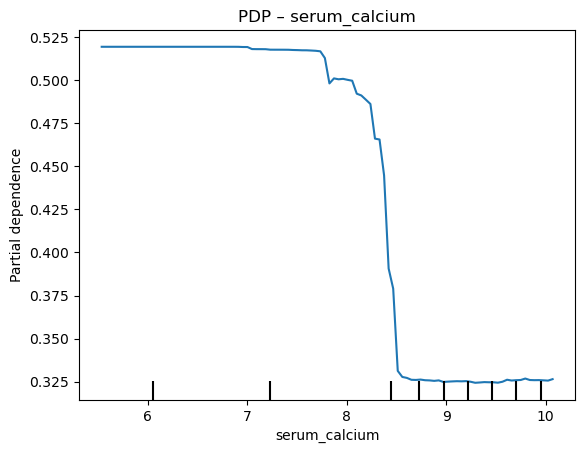

In [13]:
# 8) Interpretabilidad: Importancia permutada (PR‑AUC) y PDP
sc_pr = make_scorer(average_precision_score, needs_proba=True)

# Importancia permutada con PR-AUC sobre rf (evita el meta‑estimador calibrado para PI)
pimp = permutation_importance(rf, X_test, y_test, scoring=sc_pr, n_repeats=10, random_state=42)
imp = (pd.DataFrame({'feature': X.columns, 'importance_mean': pimp.importances_mean,
                     'importance_std': pimp.importances_std})
         .sort_values('importance_mean', ascending=False))
print(imp.head(15))

# PDP sobre 2–3 rasgos principales si existen
top_features = [f for f in imp['feature'].head(3).tolist() if f in X.columns]
for f in top_features:
    try:
        PartialDependenceDisplay.from_estimator(rf, X, [f])
        plt.title(f'PDP – {f}')
    except Exception as e:
        print('PDP falló en', f, e, '→ Si hay fuerte correlación, considera ALE.')

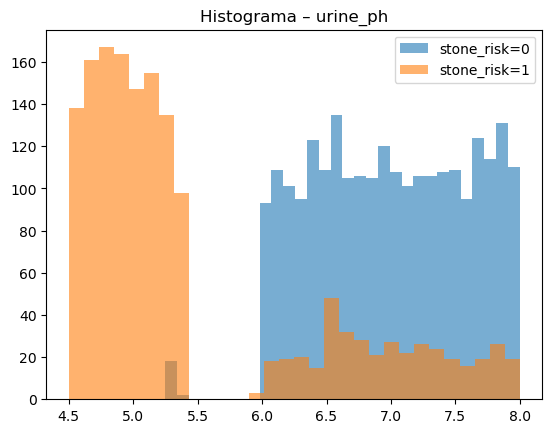

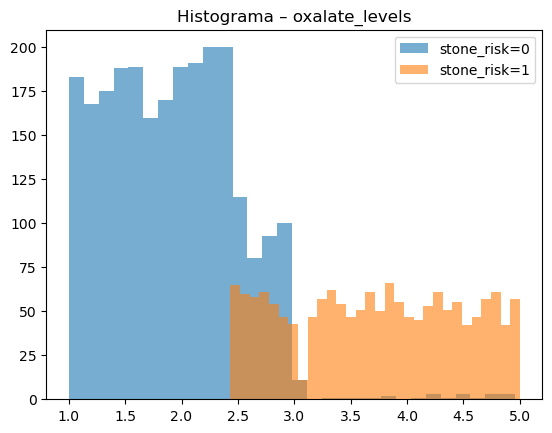

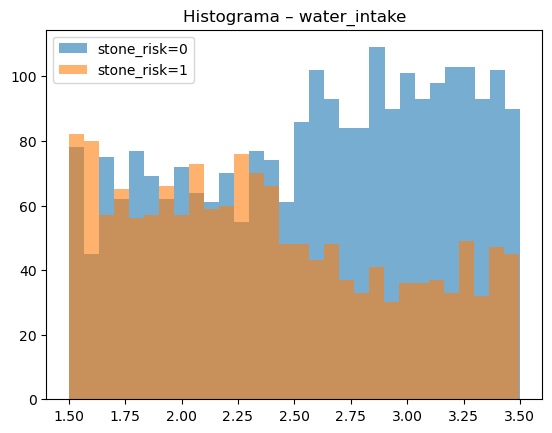

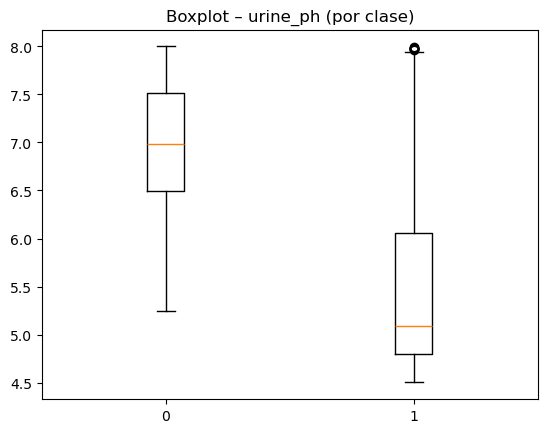

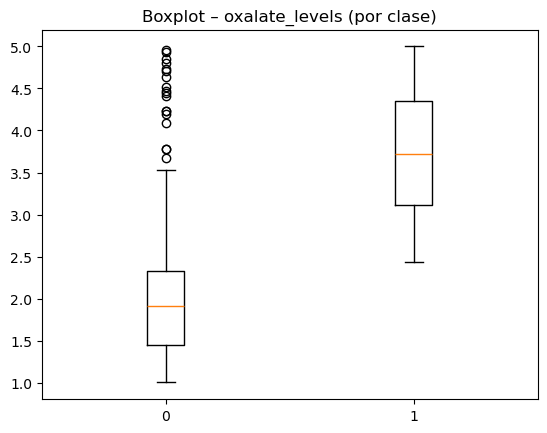

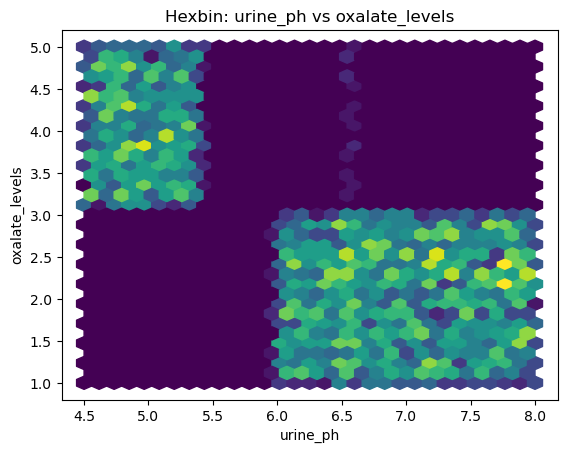

In [18]:
# 9) Visualización complementaria
# Histogramas por clase
for c in [col for col in ['urine_ph','oxalate_levels','water_intake'] if col in X.columns]:
    plt.figure()
    plt.hist(X.loc[y==0, c].dropna(), bins=30, alpha=0.6, label='stone_risk=0')
    plt.hist(X.loc[y==1, c].dropna(), bins=30, alpha=0.6, label='stone_risk=1')
    plt.title(f'Histograma – {c}')
    plt.legend()


# Boxplots por clase (matplotlib puro)
for c in [cc for cc in ['urine_ph','oxalate_levels'] if cc in X.columns]:
    plt.figure()
    data0 = X.loc[y==0, c].dropna().values
    data1 = X.loc[y==1, c].dropna().values
    plt.boxplot([data0, data1], labels=['0','1'])
    plt.title(f'Boxplot – {c} (por clase)')

# Hexbin (si existen ambas columnas)
if set(['urine_ph','oxalate_levels']).issubset(X.columns):
    plt.figure()
    plt.hexbin(X['urine_ph'], X['oxalate_levels'], gridsize=30)
    plt.xlabel('urine_ph')
    plt.ylabel('oxalate_levels')
    plt.title('Hexbin: urine_ph vs oxalate_levels')

In [16]:
# 10) Conclusiones (informe dinámico con métricas reales si están disponibles)

def _fmt_mu_sigma(mu, sd):
    return f"{mu:.3f} ± {sd:.3f}"

def _maybe(name):
    return name in globals()

lines = []
lines.append("Conclusiones (resumen)")

# --- Discriminación (CV + TEST) ---
cv_text = []
test_text = []
try:
    # Si guardaste CV explícitamente, usa esas variables; si no, recalcula rápido
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    sc_roc = make_scorer(roc_auc_score, needs_proba=True)
    sc_pr  = make_scorer(average_precision_score, needs_proba=True)

    def _cv_pair(model):
        sroc = cross_val_score(model, X_train, y_train, scoring=sc_roc, cv=cv, n_jobs=-1)
        spr  = cross_val_score(model, X_train, y_train, scoring=sc_pr,  cv=cv, n_jobs=-1)
        return sroc.mean(), sroc.std(), spr.mean(), spr.std()

    muR_lr, sdR_lr, muP_lr, sdP_lr = _cv_pair(base_lr)
    muR_rf, sdR_rf, muP_rf, sdP_rf = _cv_pair(rf)
    cv_text.append(f"LR – CV ROC-AUC { _fmt_mu_sigma(muR_lr, sdR_lr) } | CV PR-AUC { _fmt_mu_sigma(muP_lr, sdP_lr) }")
    cv_text.append(f"RF – CV ROC-AUC { _fmt_mu_sigma(muR_rf, sdR_rf) } | CV PR-AUC { _fmt_mu_sigma(muP_rf, sdP_rf) }")
except Exception as e:
    cv_text.append(f"[Nota] No se pudieron calcular/reusar las métricas CV: {e}")

try:
    from sklearn.metrics import roc_auc_score, average_precision_score
    p_lr = base_lr.predict_proba(X_test)[:, 1]
    p_rf = rf.predict_proba(X_test)[:, 1]
    test_text.append(f"LR – Test ROC-AUC {roc_auc_score(y_test, p_lr):.3f} | PR-AUC {average_precision_score(y_test, p_lr):.3f}")
    test_text.append(f"RF – Test ROC-AUC {roc_auc_score(y_test, p_rf):.3f} | PR-AUC {average_precision_score(y_test, p_rf):.3f}")
except Exception as e:
    test_text.append(f"[Nota] No se pudieron calcular las métricas en test: {e}")

lines.append("- Discriminación:\n  " + "\n  ".join(cv_text + test_text))

# --- Calibración ---
try:
    from sklearn.metrics import brier_score_loss
    if _maybe("p_rf_uncal") and _maybe("p_rf_cal"):
        b_unc = brier_score_loss(y_test, p_rf_uncal)
        b_cal = brier_score_loss(y_test, p_rf_cal)
        lines.append(f"- Calibración: Brier RF sin calibrar = {b_unc:.4f} | calibrado = {b_cal:.4f} (↓ mejor).")
    else:
        lines.append("- Calibración: (nota) ejecuta la sección de calibración para reportar Brier/fiabilidad.")
except Exception as e:
    lines.append(f"- Calibración: [Nota] No se pudo evaluar Brier: {e}")

# --- Umbral operativo ---
try:
    # si existen resultados de selección de umbral
    if _maybe("res_f1") or _maybe("res_yj") or _maybe("res_prec") or _maybe("res_cost") or _maybe("res_topk"):
        def _fmt_res(name, obj):
            return f"{name}: t={obj['threshold']:.3f} | P={obj['precision']:.3f} R={obj['recall']:.3f} F1={obj['f1']:.3f}"
        parts = []
        if _maybe("res_f1"):   parts.append(_fmt_res("F1 máx",   res_f1))
        if _maybe("res_yj"):   parts.append(_fmt_res("Youden J", res_yj))
        if _maybe("res_prec"): parts.append(_fmt_res("Prec≥min", res_prec))
        if _maybe("res_cost"): parts.append(_fmt_res("Coste",    res_cost))
        if _maybe("res_topk"): parts.append(f"Top-k: t={res_topk['threshold']:.3f}")
        lines.append("- Umbral operativo: " + " | ".join(parts))
    else:
        lines.append("- Umbral operativo: define al menos un criterio (F1/Youden/prec mínima/coste/top-k).")
except Exception as e:
    lines.append(f"- Umbral operativo: [Nota] No se pudo formatear: {e}")

# --- Variables clave (PI/PDP) ---
try:
    if _maybe("imp") and hasattr(imp, "head"):
        topk = ", ".join(imp.sort_values("importance_mean", ascending=False)["feature"].head(5).tolist())
        lines.append(f"- Variables clave: {topk} (según Permutation Importance).")
    else:
        lines.append("- Variables clave: ejecuta Importancia Permutada para listar top-k.")
except Exception as e:
    lines.append(f"- Variables clave: [Nota] No se pudo leer la PI: {e}")

# --- Límites y siguientes pasos ---
lines.append("\nLímites y siguientes pasos")
lines.append("- Dataset educativo/anonimizado: no diagnóstico; sesgos de muestra y deriva temporal posibles.")
lines.append("- Validación externa y recalibración recomendadas antes de uso clínico.")

print("\n".join(lines))

Conclusiones (resumen)
- Discriminación:
  LR – CV ROC-AUC 0.991 ± 0.003 | CV PR-AUC 0.982 ± 0.007
  RF – CV ROC-AUC 0.998 ± 0.001 | CV PR-AUC 0.997 ± 0.001
  LR – Test ROC-AUC 0.992 | PR-AUC 0.984
  RF – Test ROC-AUC 0.999 | PR-AUC 0.998
- Calibración: Brier RF sin calibrar = 0.0113 | calibrado = 0.0054 (↓ mejor).
- Umbral operativo: F1 máx: t=0.525 | P=0.987 R=1.000 F1=0.994 | Youden J: t=0.525 | P=0.987 R=1.000 F1=0.994 | Prec≥min: t=0.005 | P=0.966 R=1.000 F1=0.983 | Coste: t=0.525 | P=0.987 R=1.000 F1=0.994 | Top-k: t=1.000
- Variables clave: oxalate_levels, water_intake, serum_calcium, urine_ph, smoking (según Permutation Importance).

Límites y siguientes pasos
- Dataset educativo/anonimizado: no diagnóstico; sesgos de muestra y deriva temporal posibles.
- Validación externa y recalibración recomendadas antes de uso clínico.


In [20]:
## Avanzado

In [27]:
# Clon del dataset para no tocar el test original
df_adv = df.copy()
rng = np.random.default_rng(42)

In [28]:
#1) Inyección de nulos y ruido
# Nulos (10%) en gfr, urine_ph, water_intake (si existen)
for c in [c for c in ['gfr','urine_ph','water_intake'] if c in df_adv.columns]:
    m = rng.random(len(df_adv)) < 0.10
    df_adv.loc[m, c] = np.nan

# Ruido gaussiano suave en blood_pressure y serum_calcium con sigma relativo (0.05*std)
def add_noise_col(s, frac_std=0.05):
    sigma = frac_std * float(np.nanstd(s.values))
    return s + rng.normal(0, sigma, size=len(s))

for c in [c for c in ['blood_pressure','serum_calcium'] if c in df_adv.columns]:
    df_adv[c] = add_noise_col(df_adv[c], 0.05)

In [29]:
# Comprobación de nulos inyectados
cols_inj = [c for c in ['gfr','urine_ph','water_intake'] if c in df_adv.columns]
print("Tasa de NaN tras inyección (esperado ~0.10):")
print(df_adv[cols_inj].isna().mean().round(3).to_dict())

# Comprobación de aumento de dispersión por ruido
for c in [cc for cc in ['blood_pressure','serum_calcium'] if cc in df_adv.columns]:
    base_std = float(df[c].std())
    adv_std  = float(df_adv[c].std())
    print(f"{c}: std base={base_std:.3f} -> adv={adv_std:.3f} (Δ={adv_std - base_std:.3f})")


Tasa de NaN tras inyección (esperado ~0.10):
{'gfr': 0.102, 'urine_ph': 0.096, 'water_intake': 0.095}
blood_pressure: std base=24.684 -> adv=24.727 (Δ=0.042)
serum_calcium: std base=1.404 -> adv=1.404 (Δ=-0.000)


In [30]:
#2) Anti-leakage y split
# Repetimos Anti-leakage y split
drop_leak = [c for c in ['ckd_pred','ckd_stage','cluster','months'] if c in df_adv.columns]
y2 = df_adv['stone_risk'].astype(int)
X2 = df_adv.drop(columns=['stone_risk'] + drop_leak)
num2 = X2.select_dtypes(include='number').columns.tolist()
cat2 = [c for c in X2.columns if c not in num2]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)
    

In [31]:
print(f"X2 shape: {X2.shape} | y2 pos%: {y2.mean():.3f}")
print(f"Train/Test: {X2_train.shape[0]}/{X2_test.shape[0]} (estratificado)")
print(f"Numéricas: {len(num2)} | Categóricas: {len(cat2)} | Excluidas (leak): {drop_leak}")


X2 shape: (4000, 19) | y2 pos%: 0.392
Train/Test: 3200/800 (estratificado)
Numéricas: 11 | Categóricas: 8 | Excluidas (leak): ['ckd_pred', 'ckd_stage', 'cluster', 'months']


In [25]:
#3) Dos pipelines de imputación: M
# A) Mediana + OHE
prep_med = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler(with_mean=False))]), num2),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat2)
])
rf_med = Pipeline([('prep', prep_med), ('model', RandomForestClassifier(n_estimators=300, random_state=42))])
# B) KNNImputer + OHE (solo numéricas con KNN, categ tratadas aparte)
prep_knn = ColumnTransformer([
    ('num', Pipeline([('imp', KNNImputer(n_neighbors=5, weights='distance')), ('sc', StandardScaler(with_mean=False))]), num2),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat2)
])
rf_knn = Pipeline([('prep', prep_knn), ('model', RandomForestClassifier(n_estimators=300, random_state=42))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sc_auprc = make_scorer(average_precision_score, needs_proba=True)
sc_aucroc = make_scorer(roc_auc_score, needs_proba=True)

for name, pipe in [('RF+Mediana', rf_med), ('RF+KNN', rf_knn)]:
    s1 = cross_val_score(pipe, X2_train, y2_train, scoring=sc_aucroc, cv=cv, n_jobs=-1)
    s2 = cross_val_score(pipe, X2_train, y2_train, scoring=sc_auprc,  cv=cv, n_jobs=-1)
    pipe.fit(X2_train, y2_train); p = pipe.predict_proba(X2_test)[:,1]

    roc_test = roc_auc_score(y2_test, p)
    pr_test  = average_precision_score(y2_test, p)

    print(f"{name} – CV ROC: {s1.mean():.3f} ± {s1.std():.3f}")
    print(f"{name} – CV PR:  {s2.mean():.3f} ± {s2.std():.3f}")
    print(f"{name} – Test ROC: {roc_test:.3f}")
    print(f"{name} – Test PR:  {pr_test:.3f}")

RF+Mediana – CV ROC: 0.998 ± 0.001
RF+Mediana – CV PR:  0.996 ± 0.002
RF+Mediana – Test ROC: 0.998
RF+Mediana – Test PR:  0.997
RF+KNN – CV ROC: 0.996 ± 0.001
RF+KNN – CV PR:  0.993 ± 0.003
RF+KNN – Test ROC: 0.997
RF+KNN – Test PR:  0.995
